# 作业5：RNN 生成模型

以 `data/names.txt` 中的英文名作为训练集，利用 RNN 或 LSTM 等方法对字母序列数据进行建模，然后使用拟合的模型随机生成20个名字。本次作业为开放式，不指定各类超参数（如网络结构、学习率、迭代次数等），但需提供必要的输出和诊断结果支持你的选择（如模型是否收敛、效果评价等）。

提示：可以参照 `lec12-rnn-generation.zip` 中的代码，但注意英文名不需要像中文那样构建字典，因为可以直接使用26个字母作为字典。

In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt

In [2]:
# Read in data
df = pd.read_csv("data/names.txt", header=None, names=["name"])
names = df["name"].values

In [3]:
dict = sorted(list(set(' '.join(names))))
charset_size = len(dict)

In [4]:
# One-hot encoding
def char2index(char):
    return dict.index(char)

def name2index(name):
    return [char2index(char) for char in name]

def char2tensor(char):
    tensor = torch.zeros(1, charset_size)
    tensor[0, char2index(char)] = 1
    return tensor

def name2tensor(name):
    tensor = torch.zeros(len(name), 1, charset_size)
    for i, char in enumerate(name):
        tensor[i, 0, char2index(char)] = 1
    return tensor

def names2tensor(names): # 多个名字生成tensor
    n = len(names)
    lens = [len(name) for name in names]
    max_len = np.max(lens)
    tensor = torch.zeros(max_len, n, charset_size)
    target = torch.zeros(max_len, n, dtype=int) + charset_size - 1
    for i in range(n):
        name = names[i]             # the i-th name
        for j in range(len(name)):  # the j-th character in the name
            tensor[j, i, char2index(name[j])] = 1
            if j < len(name) - 1:
                target[j, i] = char2index(name[j + 1])
    return tensor, np.array(lens), target

In [5]:
# Build model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, input_size)
        self.o2o = nn.Linear(hidden_size + input_size, input_size)
        self.dropout = nn.Dropout(0.1)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = torch.relu(self.i2h(input_combined))
        output = torch.relu(self.i2o(input_combined))
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.logsoftmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

epoch 0, batch 0, loss = 3.2969627380371094
epoch 0, batch 10, loss = 2.9373221397399902
epoch 1, batch 0, loss = 2.8834667205810547
epoch 1, batch 10, loss = 2.8015756607055664
epoch 2, batch 0, loss = 2.7836809158325195
epoch 2, batch 10, loss = 2.7373290061950684
epoch 3, batch 0, loss = 2.7056679725646973
epoch 3, batch 10, loss = 2.672044515609741
epoch 4, batch 0, loss = 2.602294445037842
epoch 4, batch 10, loss = 2.5871334075927734
epoch 5, batch 0, loss = 2.5631070137023926
epoch 5, batch 10, loss = 2.4734745025634766
epoch 6, batch 0, loss = 2.4258341789245605
epoch 6, batch 10, loss = 2.421079158782959
epoch 7, batch 0, loss = 2.3706090450286865
epoch 7, batch 10, loss = 2.3709874153137207
epoch 8, batch 0, loss = 2.3819985389709473
epoch 8, batch 10, loss = 2.290438413619995
epoch 9, batch 0, loss = 2.292527914047241
epoch 9, batch 10, loss = 2.279325485229492
epoch 10, batch 0, loss = 2.284480571746826
epoch 10, batch 10, loss = 2.2038068771362305
epoch 11, batch 0, loss = 

epoch 91, batch 0, loss = 1.6173217296600342
epoch 91, batch 10, loss = 1.5973033905029297
epoch 92, batch 0, loss = 1.5905344486236572
epoch 92, batch 10, loss = 1.5781090259552002
epoch 93, batch 0, loss = 1.611818552017212
epoch 93, batch 10, loss = 1.6299400329589844
epoch 94, batch 0, loss = 1.5551139116287231
epoch 94, batch 10, loss = 1.6164580583572388
epoch 95, batch 0, loss = 1.5976722240447998
epoch 95, batch 10, loss = 1.614891529083252
epoch 96, batch 0, loss = 1.574932336807251
epoch 96, batch 10, loss = 1.5866857767105103
epoch 97, batch 0, loss = 1.5816433429718018
epoch 97, batch 10, loss = 1.5534515380859375
epoch 98, batch 0, loss = 1.6020699739456177
epoch 98, batch 10, loss = 1.5902892351150513
epoch 99, batch 0, loss = 1.5860950946807861
epoch 99, batch 10, loss = 1.5627878904342651
epoch 100, batch 0, loss = 1.5932443141937256
epoch 100, batch 10, loss = 1.5755864381790161
epoch 101, batch 0, loss = 1.5901159048080444
epoch 101, batch 10, loss = 1.602110028266906

epoch 180, batch 0, loss = 1.3753920793533325
epoch 180, batch 10, loss = 1.3847649097442627
epoch 181, batch 0, loss = 1.3237630128860474
epoch 181, batch 10, loss = 1.3291271924972534
epoch 182, batch 0, loss = 1.3027620315551758
epoch 182, batch 10, loss = 1.362947702407837
epoch 183, batch 0, loss = 1.3122856616973877
epoch 183, batch 10, loss = 1.3408169746398926
epoch 184, batch 0, loss = 1.3290207386016846
epoch 184, batch 10, loss = 1.328998327255249
epoch 185, batch 0, loss = 1.3340861797332764
epoch 185, batch 10, loss = 1.3393166065216064
epoch 186, batch 0, loss = 1.3035235404968262
epoch 186, batch 10, loss = 1.3790380954742432
epoch 187, batch 0, loss = 1.3296318054199219
epoch 187, batch 10, loss = 1.3438464403152466
epoch 188, batch 0, loss = 1.3025944232940674
epoch 188, batch 10, loss = 1.3497638702392578
epoch 189, batch 0, loss = 1.3491426706314087
epoch 189, batch 10, loss = 1.3366336822509766
epoch 190, batch 0, loss = 1.3222813606262207
epoch 190, batch 10, loss 

epoch 269, batch 0, loss = 1.1751842498779297
epoch 269, batch 10, loss = 1.26460862159729
epoch 270, batch 0, loss = 1.2127184867858887
epoch 270, batch 10, loss = 1.2703850269317627
epoch 271, batch 0, loss = 1.2351068258285522
epoch 271, batch 10, loss = 1.2289752960205078
epoch 272, batch 0, loss = 1.2502962350845337
epoch 272, batch 10, loss = 1.260253667831421
epoch 273, batch 0, loss = 1.2480734586715698
epoch 273, batch 10, loss = 1.2375608682632446
epoch 274, batch 0, loss = 1.1879023313522339
epoch 274, batch 10, loss = 1.2599174976348877
epoch 275, batch 0, loss = 1.2296050786972046
epoch 275, batch 10, loss = 1.2479615211486816
epoch 276, batch 0, loss = 1.2334349155426025
epoch 276, batch 10, loss = 1.2471446990966797
epoch 277, batch 0, loss = 1.2408778667449951
epoch 277, batch 10, loss = 1.2568575143814087
epoch 278, batch 0, loss = 1.2350820302963257
epoch 278, batch 10, loss = 1.226196527481079
epoch 279, batch 0, loss = 1.193984031677246
epoch 279, batch 10, loss = 1

epoch 358, batch 0, loss = 1.1916484832763672
epoch 358, batch 10, loss = 1.201963186264038
epoch 359, batch 0, loss = 1.1819316148757935
epoch 359, batch 10, loss = 1.2081170082092285
epoch 360, batch 0, loss = 1.1602966785430908
epoch 360, batch 10, loss = 1.1885794401168823
epoch 361, batch 0, loss = 1.1756858825683594
epoch 361, batch 10, loss = 1.2251107692718506
epoch 362, batch 0, loss = 1.1787587404251099
epoch 362, batch 10, loss = 1.1910831928253174
epoch 363, batch 0, loss = 1.1745951175689697
epoch 363, batch 10, loss = 1.201953411102295
epoch 364, batch 0, loss = 1.1648727655410767
epoch 364, batch 10, loss = 1.2117030620574951
epoch 365, batch 0, loss = 1.16517174243927
epoch 365, batch 10, loss = 1.1745357513427734
epoch 366, batch 0, loss = 1.1753227710723877
epoch 366, batch 10, loss = 1.2143285274505615
epoch 367, batch 0, loss = 1.1641565561294556
epoch 367, batch 10, loss = 1.199570655822754
epoch 368, batch 0, loss = 1.162977695465088
epoch 368, batch 10, loss = 1.

epoch 447, batch 0, loss = 1.163827896118164
epoch 447, batch 10, loss = 1.177827000617981
epoch 448, batch 0, loss = 1.1531236171722412
epoch 448, batch 10, loss = 1.1768779754638672
epoch 449, batch 0, loss = 1.143873691558838
epoch 449, batch 10, loss = 1.2048168182373047
epoch 450, batch 0, loss = 1.1296319961547852
epoch 450, batch 10, loss = 1.1831231117248535
epoch 451, batch 0, loss = 1.121256947517395
epoch 451, batch 10, loss = 1.1630762815475464
epoch 452, batch 0, loss = 1.1326439380645752
epoch 452, batch 10, loss = 1.1839234828948975
epoch 453, batch 0, loss = 1.0983054637908936
epoch 453, batch 10, loss = 1.1613823175430298
epoch 454, batch 0, loss = 1.1094558238983154
epoch 454, batch 10, loss = 1.176247000694275
epoch 455, batch 0, loss = 1.1412992477416992
epoch 455, batch 10, loss = 1.1558821201324463
epoch 456, batch 0, loss = 1.129565954208374
epoch 456, batch 10, loss = 1.1613059043884277
epoch 457, batch 0, loss = 1.1063333749771118
epoch 457, batch 10, loss = 1.

epoch 536, batch 0, loss = 1.1171306371688843
epoch 536, batch 10, loss = 1.1448478698730469
epoch 537, batch 0, loss = 1.1284315586090088
epoch 537, batch 10, loss = 1.1392199993133545
epoch 538, batch 0, loss = 1.1150623559951782
epoch 538, batch 10, loss = 1.150464653968811
epoch 539, batch 0, loss = 1.1165471076965332
epoch 539, batch 10, loss = 1.1404813528060913
epoch 540, batch 0, loss = 1.1220109462738037
epoch 540, batch 10, loss = 1.170595645904541
epoch 541, batch 0, loss = 1.128596544265747
epoch 541, batch 10, loss = 1.1309689283370972
epoch 542, batch 0, loss = 1.1101676225662231
epoch 542, batch 10, loss = 1.1222918033599854
epoch 543, batch 0, loss = 1.1062655448913574
epoch 543, batch 10, loss = 1.1322863101959229
epoch 544, batch 0, loss = 1.1067650318145752
epoch 544, batch 10, loss = 1.1498750448226929
epoch 545, batch 0, loss = 1.115163803100586
epoch 545, batch 10, loss = 1.092818260192871
epoch 546, batch 0, loss = 1.127568244934082
epoch 546, batch 10, loss = 1.

epoch 624, batch 10, loss = 1.1267247200012207
epoch 625, batch 0, loss = 1.1082921028137207
epoch 625, batch 10, loss = 1.1189370155334473
epoch 626, batch 0, loss = 1.0922105312347412
epoch 626, batch 10, loss = 1.121978998184204
epoch 627, batch 0, loss = 1.1150538921356201
epoch 627, batch 10, loss = 1.1168782711029053
epoch 628, batch 0, loss = 1.100760817527771
epoch 628, batch 10, loss = 1.1439194679260254
epoch 629, batch 0, loss = 1.1043295860290527
epoch 629, batch 10, loss = 1.1398191452026367
epoch 630, batch 0, loss = 1.1055340766906738
epoch 630, batch 10, loss = 1.1229591369628906
epoch 631, batch 0, loss = 1.1290671825408936
epoch 631, batch 10, loss = 1.1211156845092773
epoch 632, batch 0, loss = 1.0943241119384766
epoch 632, batch 10, loss = 1.1252071857452393
epoch 633, batch 0, loss = 1.0947024822235107
epoch 633, batch 10, loss = 1.143097996711731
epoch 634, batch 0, loss = 1.0979020595550537
epoch 634, batch 10, loss = 1.107473373413086
epoch 635, batch 0, loss = 

epoch 713, batch 10, loss = 1.1393016576766968
epoch 714, batch 0, loss = 1.1346549987792969
epoch 714, batch 10, loss = 1.1249308586120605
epoch 715, batch 0, loss = 1.064928412437439
epoch 715, batch 10, loss = 1.1024603843688965
epoch 716, batch 0, loss = 1.1006531715393066
epoch 716, batch 10, loss = 1.107635498046875
epoch 717, batch 0, loss = 1.1098254919052124
epoch 717, batch 10, loss = 1.1094987392425537
epoch 718, batch 0, loss = 1.089153528213501
epoch 718, batch 10, loss = 1.097440481185913
epoch 719, batch 0, loss = 1.0841424465179443
epoch 719, batch 10, loss = 1.1182948350906372
epoch 720, batch 0, loss = 1.0866148471832275
epoch 720, batch 10, loss = 1.1500567197799683
epoch 721, batch 0, loss = 1.1031101942062378
epoch 721, batch 10, loss = 1.091550350189209
epoch 722, batch 0, loss = 1.0993647575378418
epoch 722, batch 10, loss = 1.1329857110977173
epoch 723, batch 0, loss = 1.0890049934387207
epoch 723, batch 10, loss = 1.1000862121582031
epoch 724, batch 0, loss = 1

epoch 802, batch 10, loss = 1.106975793838501
epoch 803, batch 0, loss = 1.0760031938552856
epoch 803, batch 10, loss = 1.1020159721374512
epoch 804, batch 0, loss = 1.0748591423034668
epoch 804, batch 10, loss = 1.1166325807571411
epoch 805, batch 0, loss = 1.0864214897155762
epoch 805, batch 10, loss = 1.1191229820251465
epoch 806, batch 0, loss = 1.068910837173462
epoch 806, batch 10, loss = 1.132519245147705
epoch 807, batch 0, loss = 1.0925166606903076
epoch 807, batch 10, loss = 1.0963599681854248
epoch 808, batch 0, loss = 1.0977411270141602
epoch 808, batch 10, loss = 1.1162011623382568
epoch 809, batch 0, loss = 1.0705417394638062
epoch 809, batch 10, loss = 1.1157008409500122
epoch 810, batch 0, loss = 1.0926308631896973
epoch 810, batch 10, loss = 1.1232690811157227
epoch 811, batch 0, loss = 1.0913276672363281
epoch 811, batch 10, loss = 1.1337062120437622
epoch 812, batch 0, loss = 1.0618634223937988
epoch 812, batch 10, loss = 1.0957715511322021
epoch 813, batch 0, loss =

epoch 891, batch 10, loss = 1.1001756191253662
epoch 892, batch 0, loss = 1.0558871030807495
epoch 892, batch 10, loss = 1.0658602714538574
epoch 893, batch 0, loss = 1.0885372161865234
epoch 893, batch 10, loss = 1.0794689655303955
epoch 894, batch 0, loss = 1.0754868984222412
epoch 894, batch 10, loss = 1.0689809322357178
epoch 895, batch 0, loss = 1.1124475002288818
epoch 895, batch 10, loss = 1.1153347492218018
epoch 896, batch 0, loss = 1.0862163305282593
epoch 896, batch 10, loss = 1.1005799770355225
epoch 897, batch 0, loss = 1.0887900590896606
epoch 897, batch 10, loss = 1.091552495956421
epoch 898, batch 0, loss = 1.0425182580947876
epoch 898, batch 10, loss = 1.1202703714370728
epoch 899, batch 0, loss = 1.0431642532348633
epoch 899, batch 10, loss = 1.114166259765625
epoch 900, batch 0, loss = 1.041200876235962
epoch 900, batch 10, loss = 1.08720064163208
epoch 901, batch 0, loss = 1.03581702709198
epoch 901, batch 10, loss = 1.1102099418640137
epoch 902, batch 0, loss = 1.0

epoch 980, batch 0, loss = 1.0693023204803467
epoch 980, batch 10, loss = 1.0962200164794922
epoch 981, batch 0, loss = 1.0199147462844849
epoch 981, batch 10, loss = 1.059032678604126
epoch 982, batch 0, loss = 1.0365898609161377
epoch 982, batch 10, loss = 1.1079068183898926
epoch 983, batch 0, loss = 1.0691657066345215
epoch 983, batch 10, loss = 1.104017734527588
epoch 984, batch 0, loss = 1.0605571269989014
epoch 984, batch 10, loss = 1.0882439613342285
epoch 985, batch 0, loss = 1.0757091045379639
epoch 985, batch 10, loss = 1.1132961511611938
epoch 986, batch 0, loss = 1.073306918144226
epoch 986, batch 10, loss = 1.0713855028152466
epoch 987, batch 0, loss = 1.0495681762695312
epoch 987, batch 10, loss = 1.0690783262252808
epoch 988, batch 0, loss = 1.0810670852661133
epoch 988, batch 10, loss = 1.1348832845687866
epoch 989, batch 0, loss = 1.049941062927246
epoch 989, batch 10, loss = 1.1322011947631836
epoch 990, batch 0, loss = 1.0873275995254517
epoch 990, batch 10, loss = 

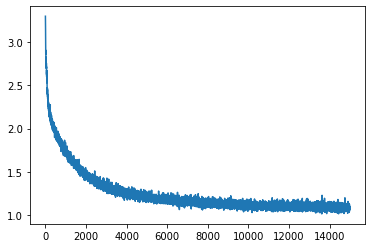

In [6]:
np.random.seed(123)
torch.random.manual_seed(123)
device = torch.device("cuda")
# device = torch.device("cpu")  # If no GPU on the machine

# train_id = np.random.choice(len(dat), 10000)
# train = [dat[i] for i in train_id]
train = names

n = len(train)
n_hidden = 256
nepoch = 1000
bs = 256

rnn = RNN(charset_size, n_hidden)
rnn = rnn.to(device=device)
opt = torch.optim.Adam(rnn.parameters(), lr=0.001)
train_ind = np.arange(n)
lossfn = nn.NLLLoss(reduction="none")
losses = []

t1 = time.time()
for k in range(nepoch):
    np.random.shuffle(train_ind)
    # Update on mini-batches
    for j in range(0, n, bs):
        # Create mini-batch
        ind = train_ind[j:(j + bs)]
        mb = [train[i] for i in ind]
        mb_size = len(mb)
        input, actual_len, target = names2tensor(mb)
        input = input.to(device=device)
        target = target.to(device=device)
        max_len = input.shape[0]
        hidden = rnn.init_hidden(mb_size).to(device=device)
        loss = 0.0
        for s in range(max_len):
            output, hidden = rnn(input[s], hidden)
            loss_s = lossfn(output, target[s])
            valid = torch.tensor((s < actual_len).astype(int)).to(device=device)
            loss = loss + loss_s * valid
        loss = torch.mean(loss / torch.tensor(actual_len).to(device=device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if j // bs % 10 == 0:
            print(f"epoch {k}, batch {j // bs}, loss = {loss.item()}")
t2 = time.time()
print(t2 - t1)
plt.plot(losses)

In [9]:
rnn.eval()
family_names = np.unique([name[0] for name in names])
def random_family_name():
    return np.random.choice(family_names, 1)[0]

def random_name(max_len=4):
    rnn.eval()
    family_name = random_family_name()
    input = char2tensor(family_name).to(device=device)
    char_ind = [torch.argmax(input).item()]
    hidden = rnn.init_hidden(batch_size=1).to(device=device)
    for i in range(max_len - 1):
        output, hidden = rnn(input, hidden)
        ind = torch.argmax(output).item()
        if ind == charset_size - 1:
            break
        char_ind.append(ind)
        input.zero_()
        input[0, ind] = 1.0
    return char_ind

np.random.seed(123)
torch.random.manual_seed(123)
ind = random_name(10)
print("".join([dict[i] for i in ind]))

newbury


In [10]:
np.random.seed(123)
torch.random.manual_seed(123)
names = []
for i in range(20):
    ind = random_name(10)
    names.append("".join([dict[i] for i in ind]))
np.set_printoptions(linewidth=50)
print(np.array(names))

['newbury' 'collins' 'collins' 'greenall' 'robb'
 'tomes' 'kenneford' 'wallis' 'barrow' 'allam'
 'robb' 'parkin' 'jennison' 'allam' 'orme'
 'allam' 'parkin' 'tomes' 'orme' 'elliot']
